In [1]:
from keras import layers
import keras
import keras.backend as K
from matplotlib import pyplot as plt
from pylab import rcParams
from keras.layers import Activation, Dense,Dot,merge, Dropout,Lambda,Permute,Multiply,LSTM, Conv2D, Flatten, MaxPooling2D, LSTM,RepeatVector,Reshape,TimeDistributed,UpSampling1D
# import common as com
import keras.models
from keras import backend as K
from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.models import Model
# from keras.layers.wrappers import TimeDistributed

Using TensorFlow backend.
In C:\Users\Vibrastic\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Vibrastic\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Vibrastic\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Vibrastic\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Vibrastic\Anaconda3\lib\site-packages\

In [2]:
width = 128
height = 64
channels = 1
input_dim = 640
timesteps = 10
n_features = 64
lr = 0.001
batch_size = 1

In [3]:
import keras.backend as K
import numpy as np

numpyA = np.ones([1,64])

def multA(x):
    A = K.variable(np.ones([1,64]))

    return K.dot(x,A)
# def multa(x)
def multA_T(x):
    A = K.variable(np.ones([1,10]))

    return K.dot(x,A)
# weight_2 = Lambda(lambda x:x*0.2)
# weight_gru1 = weight_2(gru1)
# output = Lambda(lambda x: K.sum(x, axis=-1))(vec)
# model.add(Lambda(multA))

In [4]:
#-------------------------------------------#
#   注意力模块
#-------------------------------------------#
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, lstm_units)

    # (batch_size, time_steps, lstm_units) -> (batch_size, lstm_units, time_steps)
    a = Permute((2, 1))(inputs)

    # 对最后一维进行全连接
    # (batch_size, lstm_units, time_steps) -> (batch_size, lstm_units, time_steps)
    a = Dense(10, activation='softmax')(a)

    # (batch_size, lstm_units, time_steps) -> (batch_size, time_steps, lstm_units)
    a_probs = Permute((2, 1), name='attention_vec')(a)

    # 相乘
    # 相当于获得每一个step中，每个维度在所有step中的权重
    output_attention_mul = Multiply()([inputs,a_probs])
#     output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

# Generator Encoder

In [5]:
import tensorflow as tf
input_layer = Input(name='input', shape=(input_dim, ))

input_layer1 = Reshape((timesteps,64))(input_layer)#[10,64]
att = TimeDistributed(Dense(64))(input_layer1)#[B,T,F]
att = Activation('sigmoid')(att)

att1 = Lambda(lambda x: K.sum(x, axis=-1))(att)
att1 = Reshape([-1,1])(att1)
att1 = Lambda(multA)(att1)
att1 = Reshape([-1,64])(att1)

att = Lambda(lambda x:x*64)(att)
att1 = Lambda(lambda x:1/x)(att1)
freq_fnorm = Multiply()([att,att1])

h = Reshape((640,))(freq_fnorm)
# h= Flatten()(cnn_input)
# print(h.shape)
h = Dense(512)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(256)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(256)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(128)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(128)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Dense(8)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

  
g_e = keras.models.Model(inputs=input_layer, outputs=h)


g_e.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 10, 64)       0           input[0][0]                      
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 10, 64)       4160        reshape_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 10, 64)       0           time_distributed_1[0][0]         
____________________________________________________________________________________________

# Generator

In [6]:
input_layer = Input(name='input', shape=(input_dim,))

x = g_e(input_layer)


y = Dense(128)(x)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Dense(128)(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Dense(256)(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Dense(256)(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Dense(512)(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Dense(input_dim)(y)


g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 640)               0         
_________________________________________________________________
model_1 (Model)              (None, 8)                 585064    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1152      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512 

# Encoder

In [7]:
input_layer = Input(name='input', shape=(input_dim, ))

input_layer1 = Reshape((timesteps,64))(input_layer)#[10,64]
att = TimeDistributed(Dense(64))(input_layer1)#[B,T,F]
att = Activation('sigmoid')(att)

att1 = Lambda(lambda x: K.sum(x, axis=-1))(att)
att1 = Reshape([-1,1])(att1)
att1 = Lambda(multA)(att1)
att1 = Reshape([-1,64])(att1)

att = Lambda(lambda x:x*64)(att)
att1 = Lambda(lambda x:1/x)(att1)
freq_fnorm = Multiply()([att,att1])
cnn_input = Multiply()([input_layer1,freq_fnorm])

z = Reshape((640,))(cnn_input)

z = Dense(512)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = Dense(256)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = Dense(256)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = Dense(128)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = Dense(128)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

z = Dense(8)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640)          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 10, 64)       0           input[0][0]                      
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 10, 64)       4160        reshape_5[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 10, 64)       0           time_distributed_2[0][0]         
____________________________________________________________________________________________

# Feature Extractor

In [8]:
input_layer = Input(name='input', shape=(input_dim,))

f = Dense(512)(input_layer)
f = BatchNormalization()(f)
f = Activation('relu')(f)

h = Dense(256)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

f = Dense(256)(f)
f = BatchNormalization()(f)
f = Activation('relu')(f)

f = Dense(128)(f)
f = BatchNormalization()(f)
f = Activation('relu')(f)

f = Dense(128)(f)
f = BatchNormalization()(f)
f = Activation('relu')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 640)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               328192    
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
activation_20 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
activation_22 (Activation)   (None, 256)               0   

# Gan Trainer

In [9]:
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(input_dim,))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 10.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=losses, loss_weights=lossWeights)


In [10]:
gan_trainer.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 640)          1166568     input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              [(None, 640), (None, 0           input[0][0]                      
                                                                 model_2[1][0]                    
__________________________________________________________________________________________________
cnt_loss (CntLoss)              [(None, 640), (None, 0           input[0][0]                

# Discriminator

In [11]:
input_layer = layers.Input(name='input', shape=(input_dim,))

f = feature_extractor(input_layer)

d = Dense(32)(f)
d = BatchNormalization()(d)
d = Activation('elu')(d)

d = layers.Dense(1, activation='sigmoid', name='d_out')(d)    

d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 640)               0         
_________________________________________________________________
model_4 (Model)              (None, 128)               513024    
_________________________________________________________________
dense_26 (Dense)             (None, 32)                4128      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
activation_25 (Activation)   (None, 32)                0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 33        
Total params: 517,313
Trainable params: 515,201
Non-trainable params: 2,112
_________________________________________________

In [12]:
d.compile(optimizer=keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')

# Load Data

  0%|                                                                                         | 0/3009 [00:00<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vibrastic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-26419edb6c49>", line 47, in <module>
    data = np.zeros((len(wav_list_c) * vectors.shape[0], dims), float)
MemoryError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vibrastic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'MemoryError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Vibrastic\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Vibrastic\A

MemoryError: 

In [15]:
x_ok.shape

(914736, 640)

In [1]:
# mencari directory saat ini
import os
os.getcwd()

'C:\\Users\\Vibrastic\\Documents'

In [2]:
# Merubah directory
os.chdir('D:\Folder Pribadi Asisten\Bagus\Training')
# Merubah directory (beneran)
os.chdir('D:/Folder Pribadi Asisten/Bagus/Training')

100%|█████████████████████████████████████████████████████████████████████████████| 3009/3009 [00:29<00:00, 102.08it/s]


(914736, 640)


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 103.53it/s]


14.892547607421875

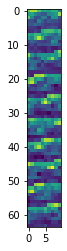

In [6]:
# from keras.datasets import mnist
# import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
# additional
import numpy as np
import librosa
from tqdm import tqdm
import librosa.core
import librosa.feature
n_mels=64
n_frames= 10
n_hop_frames= 1
n_fft= 1024
hop_length= 512
power= 2.0
in_dir_c = 'D:/Folder Pribadi Asisten/Bagus/Training/pump/train/'
wav_list_c = os.listdir(in_dir_c)
idx = 0

for  wav_file_c in tqdm(wav_list_c):     
    if wav_file_c.endswith('.wav'):
        indir_c1 = in_dir_c + wav_file_c
        dims = n_mels * n_frames
        y, sr = librosa.load(indir_c1, sr=None, mono=True)
#         y -= np.mean(y)
        mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
        log_mel_spectrogram = 20.0 / power * np.log10(np.maximum(mel_spectrogram, sys.float_info.epsilon))#(128, 313)
#         log_mel_spectrogram = np.abs(log_mel_spectrogram)
#         log_mel_spectrogram = np.mean(log_mel_spectrogram, axis=-1)
        
        n_vectors = len(log_mel_spectrogram[0, :]) - n_frames + 1
#         print(n_vectors)
        if n_vectors < 1:
            vectors = np.empty((0, dims))
        vectors = np.zeros((n_vectors, dims))#(250, 8192)
        for t in range(n_frames):
            vectors[:, n_mels * t : n_mels * (t + 1)] = log_mel_spectrogram[:, t : t + n_vectors].T
        vectors = vectors[: : n_hop_frames, :]
        if idx == 0:
            data = np.zeros((len(wav_list_c) * vectors.shape[0], dims), float)
        data[vectors.shape[0] * idx : vectors.shape[0] * (idx + 1), :] = vectors#(752250, 8192)
        idx = 1+idx
        
        #print(data[0].shape)
#x_ok = data.reshape(data.shape[0], 64, 128, 1)#[data.shape[0],64,128,1]
x_ok = data
print(x_ok.shape)

i=0
image = np.reshape(x_ok[i:i+1], (64, 10))
# image = image * 127 + 127
plt.imshow(image)  



in_dir_c1 = 'D:/Folder Pribadi Asisten/Bagus/Training/valve/source_test/'
wav_list_c1 = os.listdir(in_dir_c1)
y_test = []
idx = 0
for wav_file_c in tqdm(wav_list_c1):    
    if wav_file_c.endswith('.wav'):
#         print(wav_file_c.split('_')[4])
        if wav_file_c.split('_')[4] == 'anomaly':
            for i in range(309):
                y_test.append(0)
        else :
            for i in range(309):
                y_test.append(1)
        indir_c1 = in_dir_c1 + wav_file_c
        dims = n_mels * n_frames
        y, sr = librosa.load(indir_c1, sr=None, mono=True)
        mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
        log_mel_spectrogram = 20.0 / power * np.log10(np.maximum(mel_spectrogram, sys.float_info.epsilon))#(128, 313)
        n_vectors1 = len(log_mel_spectrogram[0, :]) - n_frames + 1
        
#         if n_vectors1 < 1:
#             vectors1 = np.empty((0, dims))
        vectors1 = np.zeros((n_vectors1, dims))#(250, 8192)
        for t in range(n_frames):
            vectors1[:, n_mels * t : n_mels * (t + 1)] = log_mel_spectrogram[:, t : t + n_vectors1].T
        vectors1 = vectors1[: : n_hop_frames, :]
        #print(vectors1.shape)
        if idx == 0:
            data1 = np.zeros((len(wav_list_c1) * vectors1.shape[0], dims), float)
        
        data1[vectors1.shape[0] * idx : vectors1.shape[0] * (idx + 1), :] = vectors1#(752250, 8192)
        idx = 1+idx
        
x_test = data1.reshape(data1.shape[0], 64, 10, 1)#[data.shape[0],64,128,1]
x_test = data1
x_ok.max()

# Training

In [8]:
niter = 20000
bz = 512


In [9]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [10]:
train_data_generator = get_data_generator(x_ok, bz)

In [16]:
min = 10000
for i in range(niter):
    
    
    if i % 1000 == 0:
        lr = 0.9
        print(lr)
    # get batch x, y ###
    x, y = train_data_generator.__next__()
    
    d = 33
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
#     print(lr)    
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y)
    
    if i % 100 == 0:
        if(g_loss[2]<min):
            min = g_loss[2]
            #print(type(g_loss[2]))
            print(g_loss[2],min)
            g.save("model/model_pump.hdf5")
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

0.9


AttributeError: 'int' object has no attribute 'trainable'